### EE 421/521 Image Processing - Spring 2021-22

## Lecture 7 - Geometric Transformations

#### 31 March 2022

In this lecture, you will learn the following:

1. How to implement bilinear interpolation
2. How to implement a 3x3 geometric transformation with forward and backward mapping
3. How to warp an image with a given scale, rotation, and translation
4. How to warp an image with a given affine transformation

*Copyright (c) 2020-2022 by Arif Tanju Erdem*

In [1]:
# import necessary packages

# reading/writing image files
from skimage import io
from skimage import color

# displaying images and plots
import matplotlib as mpl
import matplotlib.pyplot as plt

# array operations
import numpy as np

# signal processing operations
from scipy import signal

# mathematical calculations
import math

In [2]:
# display an image in original size

def my_display_actual_size(img, str_caption):
    
    dpi = mpl.rcParams['figure.dpi']
    height, width = img.shape

    # What size does the figure need to be in inches to fit the image?
    figsize = width / float(dpi), height / float(dpi)

    # Create a figure of the right size with one axes that takes up the full figure
    fig = plt.figure(figsize=figsize)
    ax = fig.add_axes([0, 0, 1, 1])

    # Hide spines, ticks, etc.
    # ax.axis('off')

    # Display the image.
    ax.imshow(img, cmap='gray', vmin=0, vmax=255, interpolation='none')

    plt.title(str_caption)
    plt.show()

    return

# end of function

In [3]:
# my function to convert to lumincance, round to nearest integer, 
# truncate to range [0, 255], and then set data

def my_imgLuminance(imgRGB):
    
    # make sure it is a color image
    dim_img = imgRGB.shape[2]    
    assert dim_img >= 3
    
    # get the luminance data
    if dim_img == 3:
        imgLum = color.rgb2gray(imgRGB)
    else:
        # ignore the alpha channel
        imgLum = color.rgb2gray(imgRGB[:,:,0:3])

    imgLum = np.round(imgLum * 255, 0)
    imgLum = np.minimum(imgLum, 255)
    imgLum = np.maximum(imgLum, 0)
    imgLum = imgLum.astype('uint8')
    
    return imgLum

# end of function

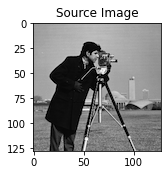

In [7]:
# set image folder
image_folder = r'C:\Users\Metin\Desktop\EE421\Week7'

# read input image 
image_file = r'/cameraman_128.tiff'
image_path = image_folder + image_file
imgSource = io.imread(image_path)

if imgSource.ndim == 3:
    # calculate the luminance image
    img = my_imgLuminance(imgSource)
else:
    img = imgSource

# display source image
my_display_actual_size(imgSource,'Source Image')

In [8]:
# my function for bilinear interpolation

def my_BilinearInterp(img, x, y):
    
    # find the four nearest integer locations
    xL = int(math.floor(x))
    xH = int(math.ceil(x))
    yL = int(math.floor(y))
    yH = int(math.ceil(y))
    
    # get the four nearest pixel intensities
    A = img[yL,xL]  
    B = img[yL,xH]  
    C = img[yH,xL]  
    D = img[yH,xH]  

    # calculate the delta values
    dx = x - xL
    dy = y - yL

    # calculate the interpolated image intensity at the interpolated location
    valInterp = (1-dy) * ((1-dx)*A + dx*B) + dy * ((1-dx)*C + dx*D)
    
    return valInterp

# end of function

---------------------------------------------------------------
### **Part 1:** Geometric Transformation with a 3x3 matrix



In [9]:
# my function for image warping using a 3x3 geometric transformation matrix

def my_warpImage(imgSource, matForward, isBackwardMapping, interpType = 'Nearest'):
    
    # get image dimensions
    srcHeight, srcWidth = imgSource.shape
    
    assert matForward.shape == (3,3)
    
    # determine source image center
    srcCenterX = srcWidth//2
    srcCenterY = srcHeight//2

    # UL: upper-left corner, UR: upper-right corner
    # LL: lower-left corner, UR: lower-right corner
    srcCornerUL = np.array([-srcCenterX, srcCenterY, 1])
    srcCornerUR = np.array([ srcCenterX, srcCenterY, 1])
    srcCornerLL = np.array([-srcCenterX,-srcCenterY, 1])
    srcCornerLR = np.array([ srcCenterX,-srcCenterY, 1])
        
    # transform the corners
    trgCornerUL = np.dot(matForward,srcCornerUL)
    trgCornerUR = np.dot(matForward,srcCornerUR)
    trgCornerLL = np.dot(matForward,srcCornerLL)
    trgCornerLR = np.dot(matForward,srcCornerLR)
    
    # find minimum & maximum x & y values
    minX = int(round(min(trgCornerUL[0], trgCornerUR[0], trgCornerLL[0], trgCornerLR[0]),0))
    maxX = int(round(max(trgCornerUL[0], trgCornerUR[0], trgCornerLL[0], trgCornerLR[0]),0))
    minY = int(round(min(trgCornerUL[1], trgCornerUR[1], trgCornerLL[1], trgCornerLR[1]),0))
    maxY = int(round(max(trgCornerUL[1], trgCornerUR[1], trgCornerLL[1], trgCornerLR[1]),0))
    
    # determine target image area
    trgWidth = maxX - minX + 1
    trgHeight = maxY - minY + 1
    
    # pick a bigger image size to account for translation
    shiftX = int(matForward[0,2])
    shiftY = int(matForward[1,2])
    trgWidth += abs(shiftX)
    trgHeight += abs(shiftY)

    # determine the target image center    
    trgCenterX = trgWidth//2
    trgCenterY = trgHeight//2

    # create target image array
    imgTarget = np.zeros((trgHeight, trgWidth))
    
    if isBackwardMapping == False: # forward mapping
        
        # map source pixels into target image using FORWARD mapping
        # start with the top-most row
        srcY = srcCenterY
        for row in imgSource:
            # start with the left-most pixel on the current row
            srcX = -srcCenterX
            for pixel in row:
                # set pixel location
                srcPixel = np.array([srcX, srcY, 1])
                # map the source pixel location into the target image
                trgPixel = np.dot(matForward, srcPixel)
                # shift by the center and flip the y axis to find actual pixel location
                # round the location to integer to find the nearest pixel location in the target image
                trgX = int(np.round(trgPixel[0]+trgCenterX-shiftX//2,0))
                trgY = int(np.round(trgPixel[1]+trgCenterY-shiftY//2,0))
                trgY = trgHeight - trgY
                # if within bounds assign values
                if trgY < trgHeight and trgY >= 0 and trgX < trgWidth and trgX >= 0:
                    # assign the target pixel value
                    imgTarget[trgY,trgX] = pixel

                # move to the next pixel to the right
                srcX += 1

            # move to the next row below
            srcY -= 1
            
        # end of loop
            
    else: # backward mapping
        
        # find backward mapping matrix by taking inverse of the forward mapping
        matBackward = np.linalg.inv(matForward)

        # map source pixels into target image using BACKWARD mapping
        # start with the top-most row
        trgY = trgCenterY
        for n in range(trgHeight):
            # start with the left-most pixel on the current row
            trgX = -trgCenterX
            for m in range(trgWidth):
                # set pixel location
                trgPixel = np.array([trgX+shiftX//2, trgY+shiftY//2, 1])
                # map the pixel location to source image
                srcPixel = np.dot(matBackward, trgPixel)
                # shift by the center and flip the y axis to find actual pixel location
                srcXfloat = srcPixel[0]+srcCenterX
                srcYfloat = srcPixel[1]+srcCenterY
                srcYfloat = srcHeight - srcYfloat

                # find nearest integer location
                srcX = int(round(srcXfloat,0))
                srcY = int(round(srcYfloat,0))
                # check if source location is within image bounds
                # (use a 1 pixel marging for bilinear mapping)
                if srcY < srcHeight-1 and srcY > 0 and srcX < srcWidth-1 and srcX > 0:
                    # assign the target pixel value
                    if interpType == 'Bilinear':
                        imgTarget[n,m] = my_BilinearInterp(imgSource, srcXfloat, srcYfloat)
                    else: #default is NearestNeighbor
                        imgTarget[n,m] = imgSource[srcY,srcX]
                        
                # move to the next pixel to the right
                trgX += 1

            # move to the next row below
            trgY -= 1
            
        # end of loop

    return imgTarget

# end of my function

---------------------------------------------------------------
### **Part 2:** Warp an image with a given scale, rotation and translation



Transformation Matrix: 
 [[ 1.08253175 -0.625       0.        ]
 [ 0.625       1.08253175  0.        ]
 [ 0.          0.          1.        ]]


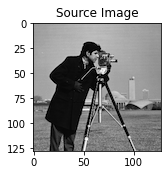

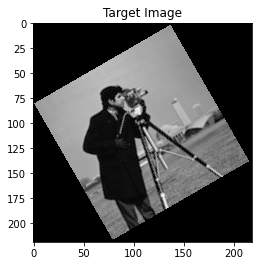

In [10]:
# Warp an image with a given scale, rotation and translation

# get image width & height
height, width = imgSource.shape

# set scale parameter
par_scale = 1.25
# set rotation parameter in degrees (around the center of image)
par_rotation = 30.0
# set translation parameter as a ratio of image width & height
par_translation = (0.0, 0.0)

# calculate the transformation parameters
s = par_scale
cT = math.cos(par_rotation*math.pi/180.0)
sT = math.sin(par_rotation*math.pi/180.0)
tx = par_translation[0]*width
ty = par_translation[1]*height

# obtain the 3x3 transformation matrix involving scale, rotation, and translation
matTrans = np.array([[s*cT, -s*sT,  tx],
                    [ s*sT,  s*cT,  ty],
                    [  0.0,   0.0, 1.0]])

print("Transformation Matrix: \n",matTrans)

# find the geometrically transformed image
# "True" below means backward mapping
imgTarget = my_warpImage(imgSource, matTrans, True, 'Bilinear')

# display source and target images
my_display_actual_size(imgSource,'Source Image')

my_display_actual_size(imgTarget,'Target Image')


---------------------------------------------------------------
### **Part 3:** Warp an image with a given affine matrix



Transformation Matrix: 
 [[0.6 0.5 0. ]
 [0.5 1.8 0. ]
 [0.  0.  1. ]]


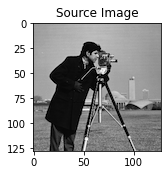

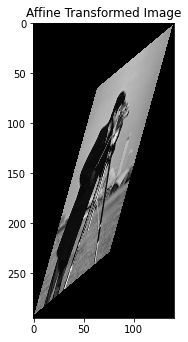

In [11]:
# Warp an image with a given affine matrix

# get image width & height
height, width = imgSource.shape

# define the 3x3 transformation matrix
matTrans_aff = np.array([[ 0.6, 0.5, 0.0],
                         [ 0.5, 1.8, 0.0],
                         [ 0.0, 0.0, 1.0]])

print("Transformation Matrix: \n", matTrans_aff)

# find the geometricaly transformed image 
# "True" below means backward mapping
imgTarget_aff = my_warpImage(imgSource, matTrans_aff, True, 'Bilinear')

# display source and target images
my_display_actual_size(imgSource,'Source Image')

my_display_actual_size(imgTarget_aff,'Affine Transformed Image')
